In [1]:
# dependencies
import pandas as pd
# Count vectorizer and TFID
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Grid Search dependencies
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier
#accuracy Score
from sklearn.metrics import accuracy_score
# classification report
from sklearn.metrics import classification_report

In [2]:
# read tokenized wine data
df = pd.read_csv('tokenized_wine_data.csv')

In [3]:
tfidf = TfidfTransformer()
cv = CountVectorizer().fit_transform(df.tokenized_sent)
bagofwords = tfidf.fit_transform(cv)

In [4]:
data = df.values
y = data[:,3]

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(200)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(bagofwords)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train, X_test, y_test = X_train[:5000], y_train[:5000], X_test[:1000], y_test[:1000]

In [8]:
# Graident Boosting Classifier
clf = GradientBoostingClassifier(random_state=42)

In [38]:
# Parameters for grid search 
param_grid = { 
    'n_estimators': [100],
    'learning_rate': [0.1, 0.2]
}

In [39]:
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)

In [40]:
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'learning_rate': [0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
CV_rfc.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [42]:
# List the best score
print(CV_rfc.best_score_)

0.4222


In [43]:
# Make predictions with the hypertuned model
predictions = CV_rfc.predict(X_test)

In [44]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

                            precision    recall  f1-score   support

  Bordeaux-style Red Blend       0.39      0.43      0.41        60
Bordeaux-style White Blend       0.25      0.10      0.14        10
            Cabernet Franc       0.00      0.00      0.00        15
        Cabernet Sauvignon       0.45      0.51      0.48       107
           Champagne Blend       0.00      0.00      0.00        11
                Chardonnay       0.49      0.78      0.60       114
                     Gamay       0.00      0.00      0.00        12
            Gewürztraminer       0.00      0.00      0.00        12
          Grüner Veltliner       0.00      0.00      0.00        16
                    Malbec       0.16      0.12      0.13        26
                    Merlot       0.17      0.08      0.11        25
                  Nebbiolo       0.53      0.35      0.42        23
              Pinot Grigio       0.00      0.00      0.00        11
                Pinot Gris       0.08      0.08

In [45]:
#from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.414

In [46]:
CV_rfc.grid_scores_

/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.42220, std: 0.01679, params: {'learning_rate': 0.1, 'n_estimators': 100},
 mean: 0.39820, std: 0.01406, params: {'learning_rate': 0.2, 'n_estimators': 100}]

In [50]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib import pyplot as plt
    from IPython.display import display
    import pandas as pd
    
    %matplotlib inline

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
   # display(pd.DataFrame(cv_results) \
            #.sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score (Gradient Boosting Classifier)\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.savefig(param_name+"_GBC.png")
        plt.show()
        

best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
best score:      0.42220 (+/-0.01675)
{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
 

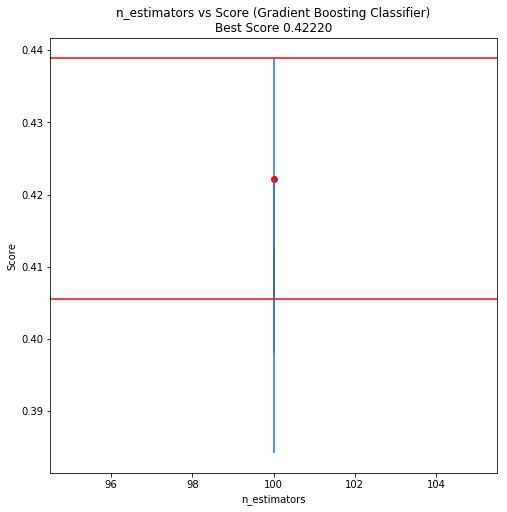

In [51]:
GridSearch_table_plot(CV_rfc, "n_estimators", negative=False)

best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
best score:      0.42220 (+/-0.01675)
{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
 

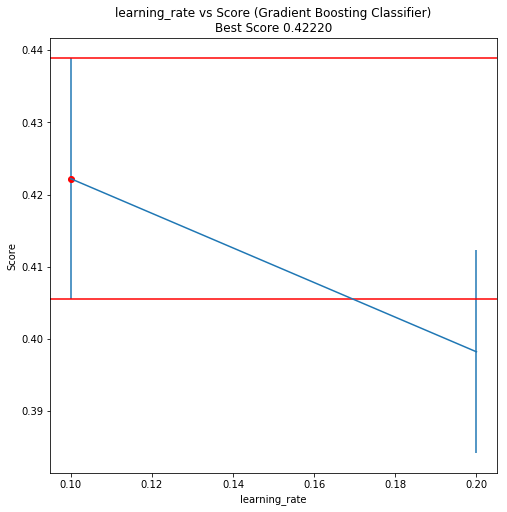

In [52]:
GridSearch_table_plot(CV_rfc, "learning_rate", negative=False)

In [54]:
# Parameters for grid search 
param_grid1 = { 
    'n_estimators': [200],
    'learning_rate': [0.1]
}

In [56]:
CV_rfc1 = GridSearchCV(estimator=clf, param_grid=param_grid1, cv= 5)

In [57]:
CV_rfc1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
CV_rfc1.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

In [59]:
# List the best score
print(CV_rfc1.best_score_)

0.4394


In [60]:
CV_rfc1.grid_scores_

/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.43940, std: 0.01606, params: {'learning_rate': 0.1, 'n_estimators': 200}]

best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
best score:      0.43940 (+/-0.01602)
{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/janakidevikora/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
 

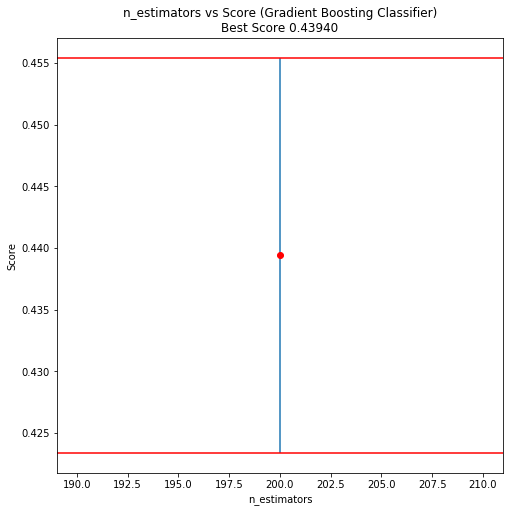

In [61]:
GridSearch_table_plot(CV_rfc1, "n_estimators", negative=False)